In [1]:
import os
import sys
import time as time_module
import datetime as dt
from datetime import datetime, timedelta, time, date
import pytz
import json
import requests
from urllib.parse import quote_plus

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer
from sklearn.pipeline import Pipeline

from tensorflow import keras
from tensorflow.keras import layers  # type: ignore
from tensorflow.keras import regularizers  # type: ignore
#from keras_tuner import HyperModel
#from keras_tuner.tuners import RandomSearch
#from kerastuner.tuners import BayesianOptimization

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sqlalchemy import create_engine

# Configuración de pandas
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_rows', 100)

#Configuración Google Colab
#from google.colab import drive
#drive.mount('/content/drive')
#sys.path.append("/content/drive/MyDrive/proyecto_prediccion_MD")

# Rutas locales
notebook_path = os.getcwd()
sys.path.append(r"C:\Users\llopez\OneDrive - Solaria Energía y Medio Ambiente\Documentos\proyecto_prediccion_MD")

from utils.connector import execute_query, insertar_dataframe_en_mysql, update_dataframe_en_mysql
from utils.format import *

En este notebook se implementará un modelo SARIMA similar al del notebook modelo_sarima_horario pero únicamente con los datos de precios desde el mes de octubre y con granularidad cuartohoraria

In [2]:

df_precio_diario = pd.read_csv(r"C:\Users\llopez\OneDrive - Solaria Energía y Medio Ambiente\Documentos\proyecto_prediccion_MD\data\precio_diario_omie.csv", sep = ";" )
df_precio_diario['Date'] = pd.to_datetime(df_precio_diario["Date"])
df_precio_diario['Month'] = df_precio_diario['Date'].dt.month
df_precio_diario['Day'] = df_precio_diario['Date'].dt.day
df_precio_diario.rename(columns={'Spain': 'Precio_DAM'}, inplace=True)
df_precio_diario['Precio_DAM'] = df_precio_diario['Precio_DAM'].str.replace(',', '.', regex=False)
df_precio_diario['Precio_DAM'] = df_precio_diario['Precio_DAM'].astype(float)
df_precio_diario.head(5)

,Date,Hour,Period,Precio_DAM,Month,Day
0,2025-01-01,1,1,134.49,1,1
1,2025-01-01,1,2,134.49,1,1
2,2025-01-01,1,3,134.49,1,1
3,2025-01-01,1,4,134.49,1,1
4,2025-01-01,2,5,131.59,1,1


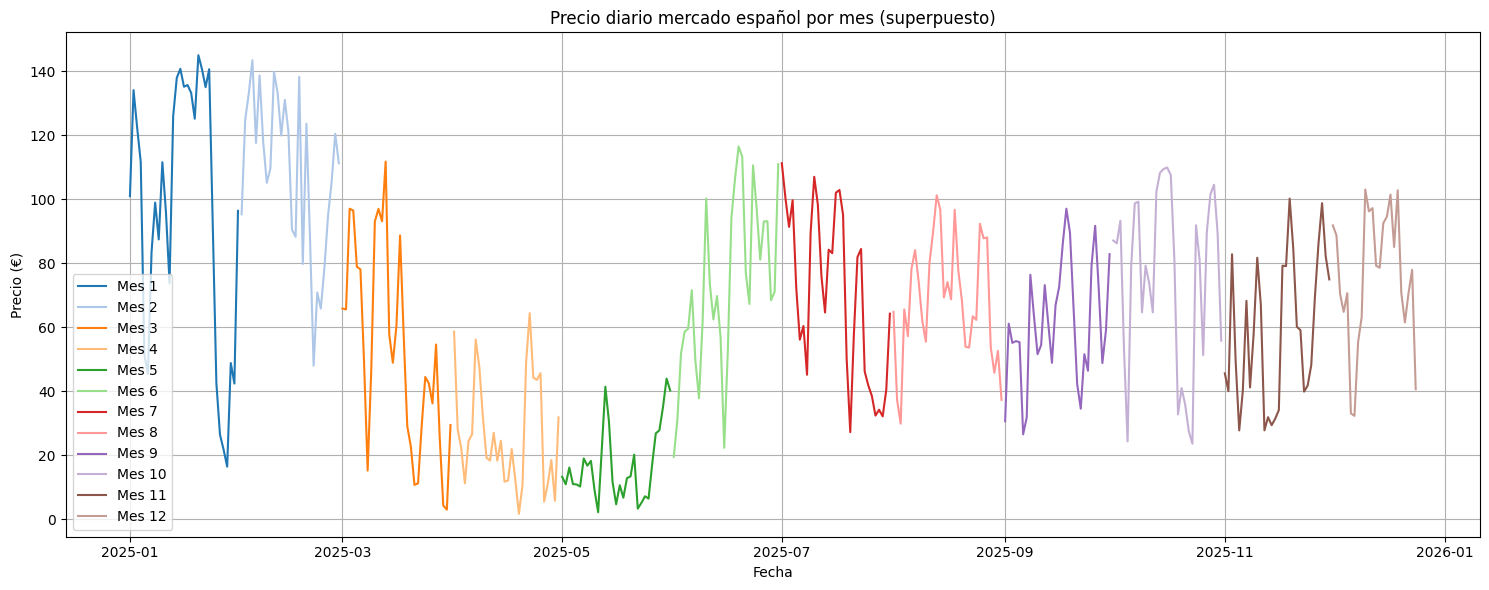

In [3]:
# Convertir a datetime
df_precio_diario['Date'] = pd.to_datetime(df_precio_diario['Date'])

# Extraer mes
df_precio_diario['Month'] = df_precio_diario['Date'].dt.month

# Resample diario si hay varias observaciones por día
df_daily = df_precio_diario.groupby(['Month', pd.Grouper(key='Date', freq='D')])['Precio_DAM'].mean().reset_index()

plt.figure(figsize=(15,6))

# Colores distintos para cada mes
colors = plt.cm.tab20.colors

for month in range(1,13):
    df_mes = df_daily[df_daily['Month'] == month].sort_values('Date')
    plt.plot(df_mes['Date'], df_mes['Precio_DAM'], label=f'Mes {month}', color=colors[month-1])

plt.title("Precio diario mercado español por mes (superpuesto)")
plt.xlabel("Fecha")
plt.ylabel("Precio (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#NOTA: Lo grafio asi y no la totalidad de la serie ya que esta tiene muchos valores entonces si se dibuja todo, queda un poco caótico

#Se puede observar que la media y varianza de la serie no es estacionaria

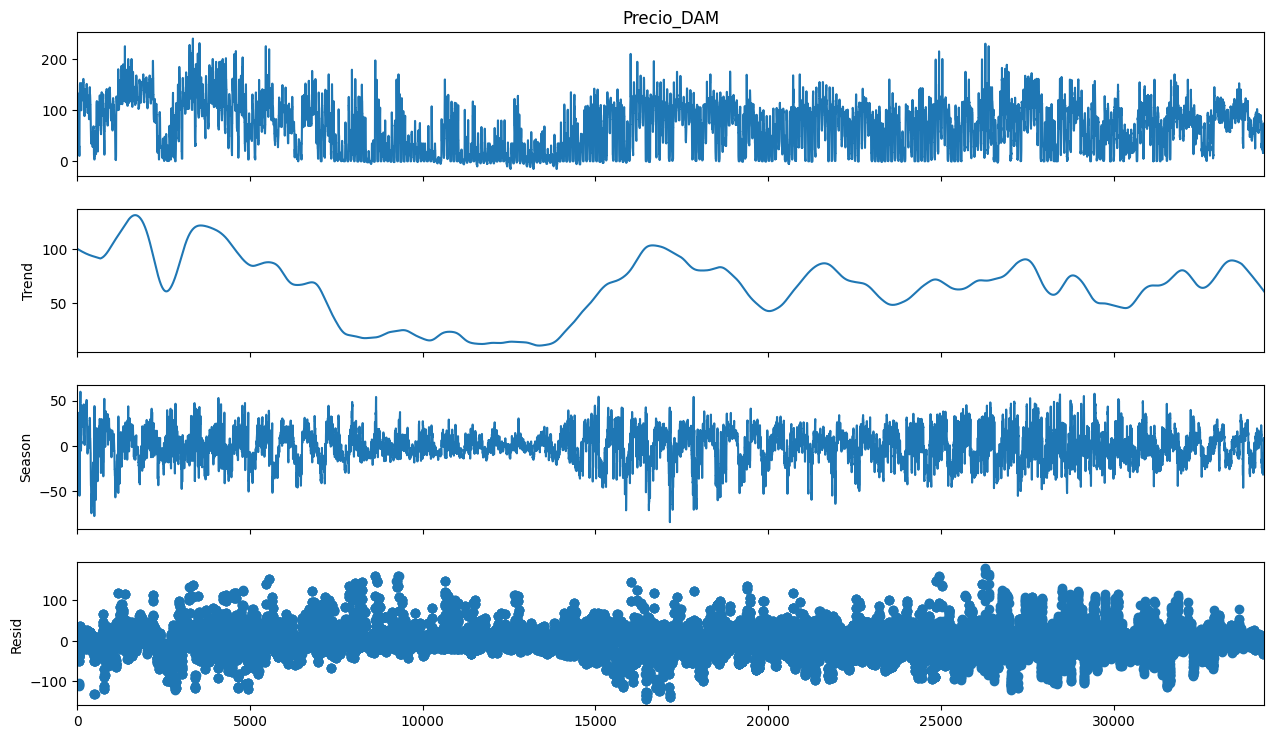

In [4]:
stl = STL(
    df_precio_diario['Precio_DAM'],
    period=692,
    robust=True
)

res = stl.fit()
fig = res.plot()
fig.set_size_inches(14, 8)  # ancho=14, alto=8
plt.show()

#La serie presenta tendencia semanal, estacionalidad y sus residuos no son ruido blanco

In [5]:
df_precio_diario.isna().sum()

Date          0
Hour          0
Period        0
Precio_DAM    0
Month         0
Day           0
dtype: int64

In [6]:
df_precio_diario['Precio_DAM'][df_precio_diario['Precio_DAM'] < 0].shape

(2206,)

#### ESTUDIO ESTACIONALIDAD EN MEDIA Y VARIANZA

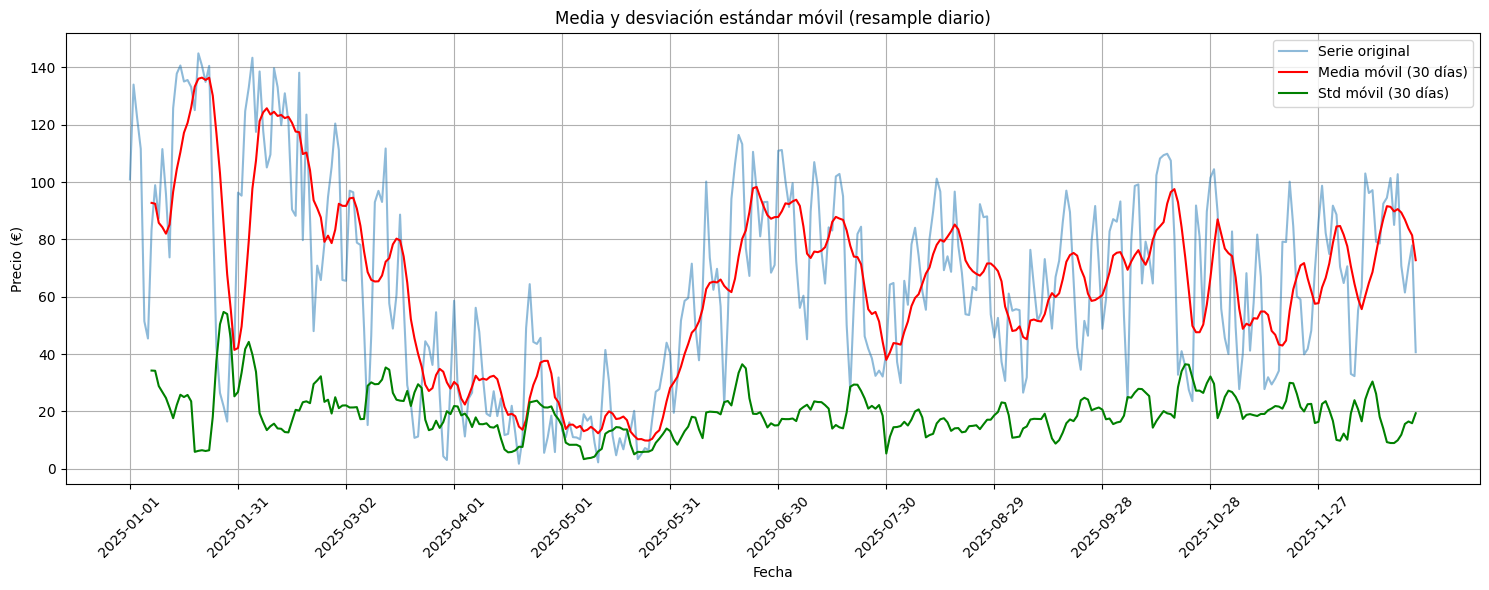

In [7]:
#¿VARIANZA ESTACIONARIA?
#-----------------------
#Para la visualización agrupamos por día para que sea más clara la visualización
# Resample diario
serie_diaria = df_precio_diario.set_index('Date')['Precio_DAM'].resample('D').mean()

rolling_mean = serie_diaria.rolling(window=7).mean()
rolling_std = serie_diaria.rolling(window=7).std()

plt.figure(figsize=(15,6))
plt.plot(serie_diaria, label='Serie original', alpha=0.5)
plt.plot(rolling_mean, color='red', label='Media móvil (30 días)')
plt.plot(rolling_std, color='green', label='Std móvil (30 días)')
plt.title("Media y desviación estándar móvil (resample diario)")
plt.xlabel("Fecha")
plt.ylabel("Precio (€)")
plt.legend()
plt.xticks(serie_diaria.index[::30], rotation=45)  # un tick cada 30 días
plt.grid(True)
plt.tight_layout()
plt.show()

#La varianza no es estacionaria y como tenemos valores negativos en la serie temporal, tenemos que aplicar Yeo-Johnson en vez de Box-Cox

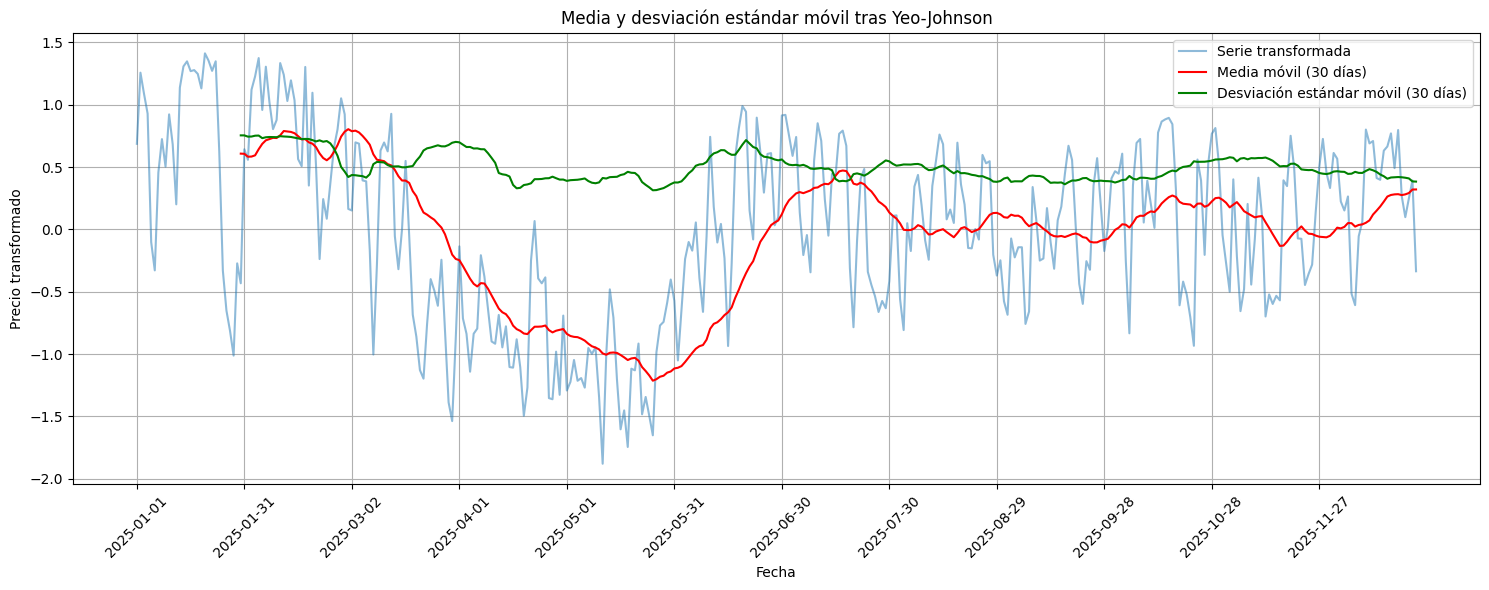

In [8]:
# Transformación Yeo-Johnson
serie = df_precio_diario['Precio_DAM'].values.reshape(-1,1)
pt = PowerTransformer(method='yeo-johnson')
serie_trans = pt.fit_transform(serie)

# Crear nueva columna en el DataFrame
df_precio_diario['Precio_DAM_trans'] = serie_trans.flatten()

# Crear Series con índice datetime
serie_trans_series = pd.Series(df_precio_diario['Precio_DAM_trans'].values, 
                               index=pd.to_datetime(df_precio_diario['Date']))
# Resample a promedio diario
serie_diaria_trans = serie_trans_series.resample('D').mean()

window = 30  # 30 días
rolling_mean = serie_diaria_trans.rolling(window=window).mean()
rolling_std = serie_diaria_trans.rolling(window=window).std()

plt.figure(figsize=(15,6))
plt.plot(serie_diaria_trans, label='Serie transformada', alpha=0.5)
plt.plot(rolling_mean, color='red', label=f'Media móvil ({window} días)')
plt.plot(rolling_std, color='green', label=f'Desviación estándar móvil ({window} días)')
plt.title("Media y desviación estándar móvil tras Yeo-Johnson")
plt.xlabel("Fecha")
plt.ylabel("Precio transformado")
plt.legend()
plt.xticks(serie_diaria_trans.index[::30], rotation=45)  # un tick cada 30 días
plt.grid(True)
plt.tight_layout()
plt.show()


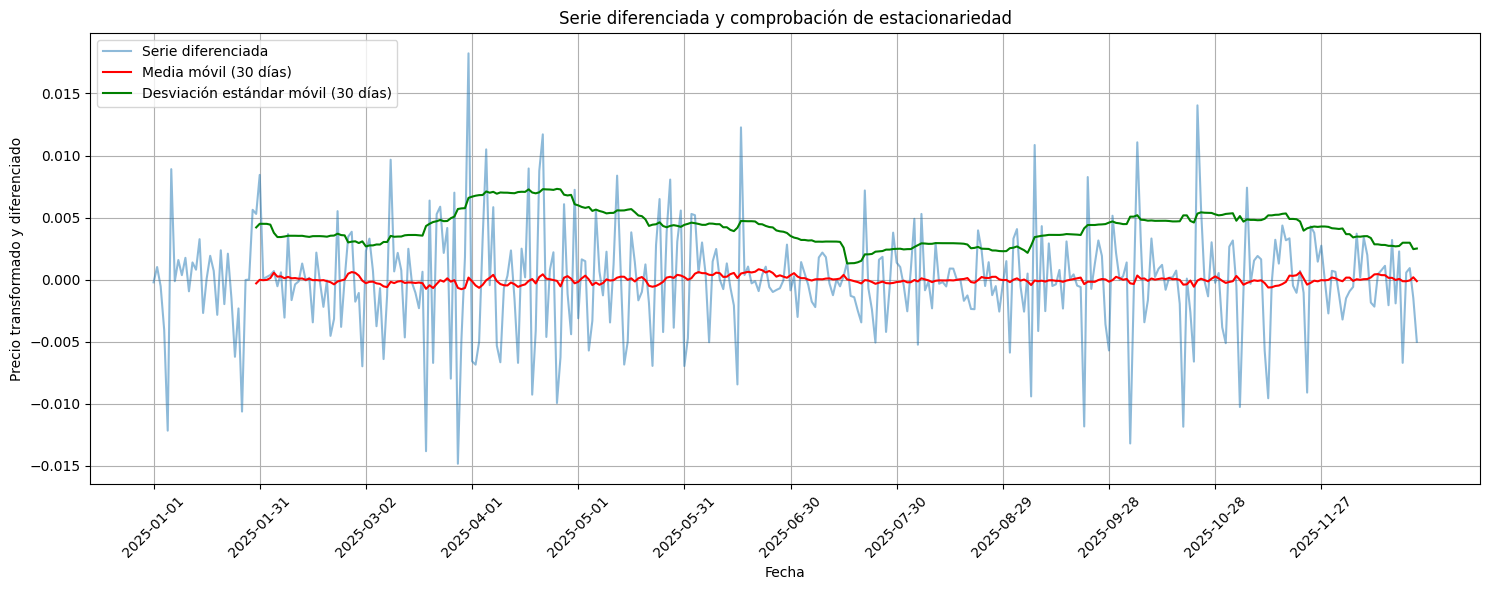

In [9]:
#OBTENER MEDIA ESTACIONARIA: Como hemos visto que la media no es estacionaria, vamos a aplicar diferenciación
#---------------------------
#La diferenciación consiste en restar el valor k anterior de cada dato de la serie

serie_diff = df_precio_diario['Precio_DAM_trans'].diff(1)
df_precio_diario['Precio_DAM_diff'] = serie_diff.values
# Crear Series con índice datetime
serie_diff_series = pd.Series(df_precio_diario['Precio_DAM_diff'].values, 
                               index=pd.to_datetime(df_precio_diario['Date']))
serie_diaria_diff = serie_diff_series.resample('D').mean()


window = 30  # 30 días
rolling_mean = serie_diaria_diff.rolling(window=window).mean()
rolling_std = serie_diaria_diff.rolling(window=window).std()

plt.figure(figsize=(15,6))
plt.plot(serie_diaria_diff, label='Serie diferenciada', alpha=0.5)
plt.plot(rolling_mean, color='red', label=f'Media móvil ({window} días)')
plt.plot(rolling_std, color='green', label=f'Desviación estándar móvil ({window} días)')
plt.title("Serie diferenciada y comprobación de estacionariedad")
plt.xlabel("Fecha")
plt.ylabel("Precio transformado y diferenciado")
plt.legend()
plt.xticks(serie_diaria_diff.index[::30], rotation=45)  # un tick cada 30 días
plt.grid(True)
plt.tight_layout()
plt.show()


Nuestra serie ya es estacionaria en media y varianza por lo que cumple las hipótesis para aplicar SARIMA   

#### ESTUDIAMOS AUTOCORRELACIONES DEL DAM

Vamos a gráficar las AutoCorrelationFunctions (ACF) y Partial AutoCorrelation Function (PACF).
1) ACF: La autocorrelación mide cómo una serie temporal (X_t) está correlacionada con sus propios valores en distintos retardos (lags). Siempre se da que p0 = 1 (correlación de la serie consigo misma) y -1 <= pk <= 1
2) PACF: Mide la autocorrelación directa entre X_t  y X_{t-k} eliminando el efecto de los retardos anteriores

In [10]:
#Seleccionamos únicamente los datos desde el 1 de octubre de 2025 momento en el que se emepezaron a recibir los datos con frecuencia cuartohoraria

df_precio_diario_qh = df_precio_diario[df_precio_diario["Date"] >= dt.datetime(2025, 10, 1)].copy()
df_precio_diario_qh.head(5)

,Date,Hour,Period,Precio_DAM,Month,Day,Precio_DAM_trans,Precio_DAM_diff
26204,2025-10-01,1,1,105.10,10,1,0.837119,0.055845
26205,2025-10-01,1,2,104.24,10,1,0.823838,-0.013281
26206,2025-10-01,1,3,102.28,10,1,0.793430,-0.030408
26207,2025-10-01,1,4,102.00,10,1,0.789070,-0.004360
26208,2025-10-01,2,5,106.63,10,1,0.860655,0.071585


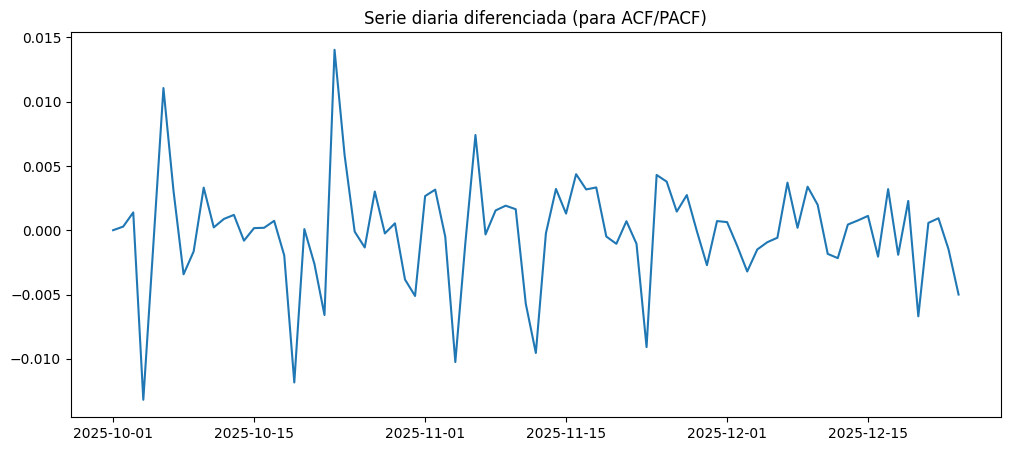

In [11]:
#La serie final (tras aplicar las transformaciones de Yeo-Johnson y diferenciación) agrupada por día sería:
serie_diaria_diff_qh = serie_diaria_diff.loc[
    serie_diaria_diff.index >= pd.Timestamp(2025, 10, 1)
].copy()
plt.figure(figsize=(12,5))
plt.plot(serie_diaria_diff_qh)
plt.title("Serie diaria diferenciada (para ACF/PACF)")
plt.show()

In [12]:
#Consideramos un 75% train y un 25% test
series = df_precio_diario_qh['Precio_DAM_trans']
series_original = df_precio_diario_qh['Precio_DAM']

# Índices para 75% y 25%
n = len(series)
train_size = int(0.75 * n)

train = series[:train_size]
test  = series[train_size:]
train_original = series_original[:train_size]
test_original = series_original[train_size:]

print(f"Train length: {len(train)}, Test length: {len(test)}")

Train length: 6123, Test length: 2041


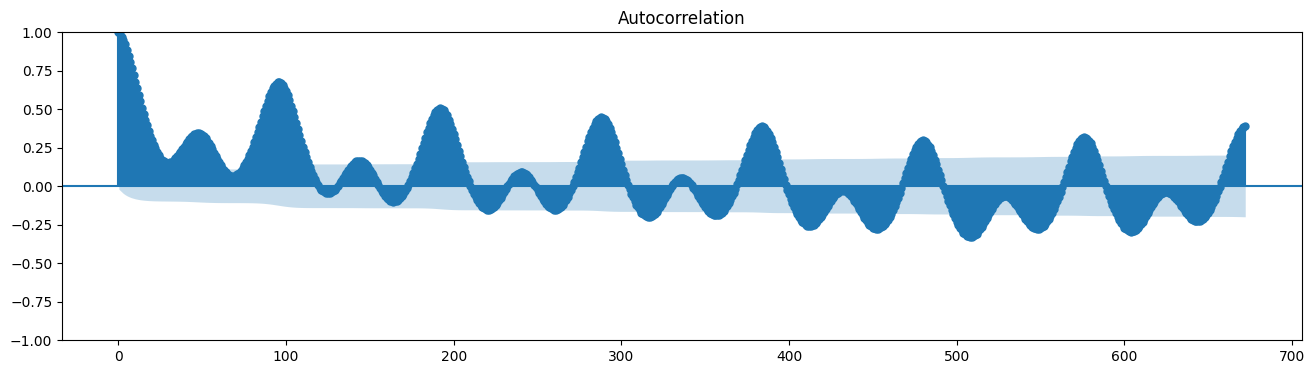

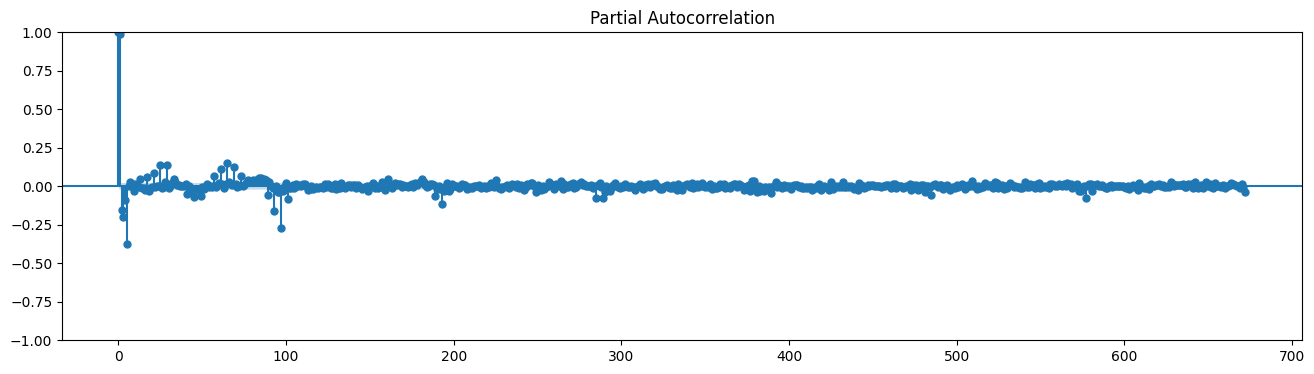

In [13]:
#Graficamos ACF y PACF para una semana y así poder detectar la estacionalidad
acf_fig = plot_acf(series, lags=672)
acf_fig.figure.set_size_inches(16,4)
plt.show()

pacf_fig = plot_pacf(series, lags=672)
pacf_fig.figure.set_size_inches(16,4)
plt.show()

#Fijándonos en el ACF y PACF vemos que las autocorrelaciones caen lentamente cada 96 pasos viendo cierto patrón diario (cada 96 muestras) por lo que la serie tendría estacionalidad s=96. 
#Además, las autocorrelaciones en los periodos de estacionalidad caen muy lentamente por lo que aplicaría D = 1

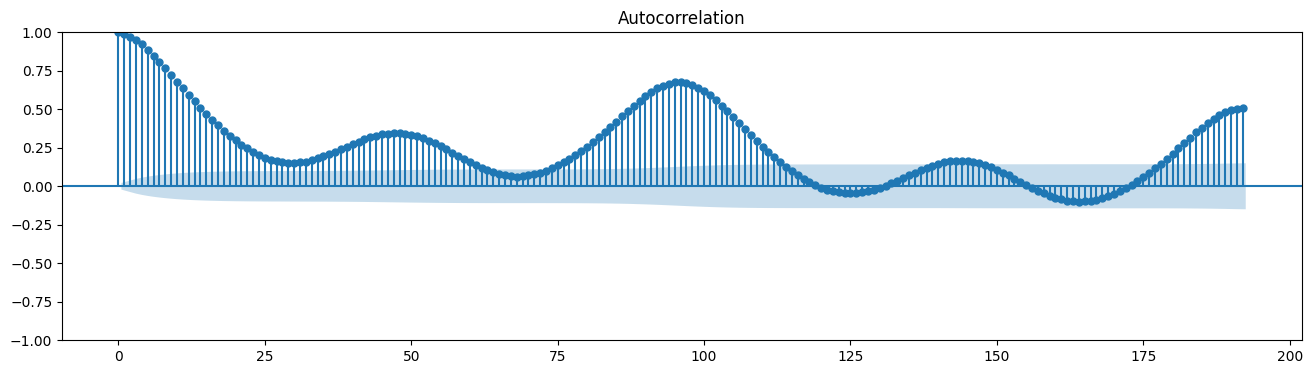

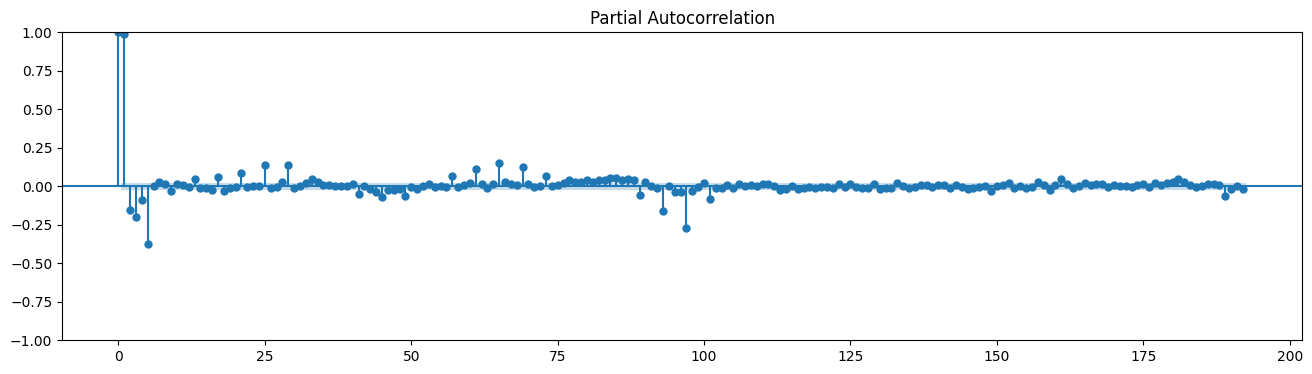

In [14]:
#Volvemos a graficar ACF, PACF pero esta vez con un horizonte de dos días para poder determinar p, q 
acf_fig = plot_acf(series, lags=192)
acf_fig.figure.set_size_inches(16,4)
plt.show()

pacf_fig = plot_pacf(series, lags=192)
pacf_fig.figure.set_size_inches(16,4)
plt.show()

#Como las autocorrelaciones caen muy lentamente en ACF, aplicaría d=1
#En PACF vemos dos autocorrelaciones bastante destacadas por lo que consideraría p = 2

#### ENTRENAMIENTO DEL MODELO

In [15]:
#MODELO SARIMA(p,d,q)(P, D, Q, s)
serie_trans = df_precio_diario_qh['Precio_DAM_trans']
model = SARIMAX(
    train,
    order=(2,1,1),           # p,d,q
    seasonal_order=(1,1,1,96), # P,D,Q,s 
    #enforce_stationarity=False, #Controla si el modelo obliga que la parte AR sea estacionaria.
    #enforce_invertibility=False #controla si la parte MA del modelo es invertible. Invertible significa que las raíces del polinomio MA están fuera del círculo unitario, lo que permite 
                                #expresar el MA como un AR infinito y facilita interpretación y predicción estable.
)

results = model.fit()
print(results.summary())

c:\Users\llopez\venv_python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\llopez\venv_python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\llopez\venv_python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MemoryError: Unable to allocate 1.73 GiB for an array with shape (195, 195, 6123) and data type float64

In [ ]:
import pickle

# Guardar el modelo ajustado
with open("sarima_model_qh_s96.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
resid = results.resid

# ACF con zoom
plt.figure(figsize=(16,4))
plot_acf(resid, lags=168, alpha=0.05, color='blue')
plt.title("ACF de residuos SARIMA")
plt.ylim(-0.1, 0.1)  # limitar eje y para ver detalles cerca de 0
plt.show()

# PACF con zoom
plt.figure(figsize=(16,4))
plot_pacf(resid, lags=168, alpha=0.05, color='blue')
plt.title("PACF de residuos SARIMA")
plt.ylim(-0.1, 0.1)
plt.show()

#### PREDICCIONES DEL MODELO 

In [ ]:
# Número de horas a predecir
n_steps = len(test)

# Predicción sobre test
forecast = results.get_forecast(steps=n_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()  # Banda de confianza

#Vamos a convertir las predicciones a la escala original
# Forecast puntual
forecast_mean_original = pt.inverse_transform(forecast_mean.values.reshape(-1,1))
# Banda de confianza: separar lower y upper
forecast_ci_lower_original = pt.inverse_transform(forecast_ci.iloc[:,0].values.reshape(-1,1))
forecast_ci_upper_original = pt.inverse_transform(forecast_ci.iloc[:,1].values.reshape(-1,1))

In [ ]:
plt.figure(figsize=(20,5))

# Test real en escala original
plt.plot(test_original.index, test_original, label='Test (real)', color='orange')

# Predicción puntual en escala original
plt.plot(test_original.index, forecast_mean_original.flatten(), label='Forecast', color='green')

# Banda de confianza en escala original
plt.fill_between(test_original.index,
                 forecast_ci_lower_original.flatten(),
                 forecast_ci_upper_original.flatten(),
                 color='lightgreen', alpha=0.3)

plt.legend()
plt.title("Predicciones SARIMA vs Test (escala original)")

# Ajustar escala del eje y
plt.ylim(min(test_original)*0.95, max(test_original)*1.05)  # un 5% por debajo y por encima de los valores reales
# Otra opción: plt.ylim(40, 80) para un rango fijo

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#RMSE: es la raíz cuadrada del error cuadrático medio (penaliza más valores grandes)
rmse = np.sqrt(mean_squared_error(test_original, forecast_mean_original))

mae  = mean_absolute_error(test_original, forecast_mean_original)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
